# Te damos la bienvenida a Colab

In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


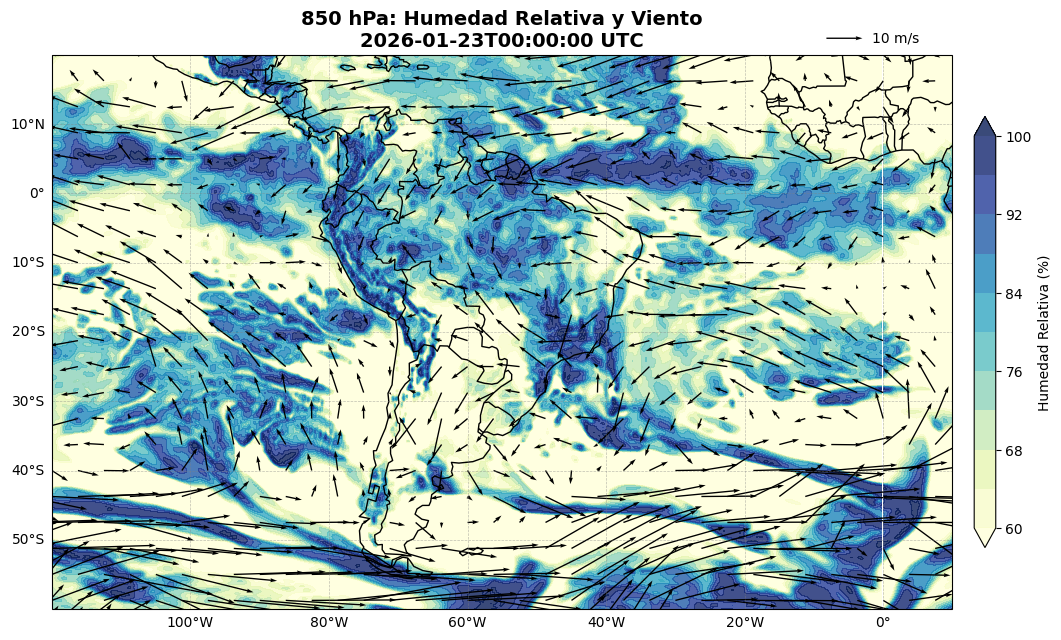

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Cargar datos
dh = xr.open_dataset(r"/content/drive/MyDrive/Colab Notebooks/humedad.nc")

# 2. Selección de nivel y fecha
fecha_query = '2026-01-23T00:00:00'
ds_850 = dh.sel(pressure_level=850, valid_time=fecha_query, method='nearest')

if 'expver' in ds_850.dims:
    ds_850 = ds_850.sel(expver=1).combine_first(ds_850.sel(expver=5))

# --- FILTRO DE ÁREA SEGURO ---
# Simplemente usamos slice para evitar el salto del meridiano 0 si es posible,
# o recortamos en dos partes si tus datos son 0-360.
# Probemos con el recorte directo de longitud para Sudamérica (0 a 20 y 240 a 360)
# Para evitar el error de espaciado, lo mejor es NO usar add_cyclic_point.
ds_final = ds_850.sel(latitude=slice(20, -70))

# 3. Graficación directa
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Extensión solicitada
ax.set_extent([-120, 10, -60, 20], crs=ccrs.PlateCarree())

# Capa 1: Humedad Relativa
niveles_hr = np.linspace(60, 100, 11)
# Usamos directamente ds_final.longitude sin procesar
im = ax.contourf(ds_final.longitude, ds_final.latitude, ds_final.r,
                 levels=niveles_hr, cmap="YlGnBu", extend='both',
                 transform=ccrs.PlateCarree(), alpha=0.8)

# Capa 2: Viento (Quiver)
skip = 15
q = ax.quiver(ds_final.longitude[::skip], ds_final.latitude[::skip],
              ds_final.u[::skip, ::skip], ds_final.v[::skip, ::skip],
              color='black', scale=250, width=0.0015, transform=ccrs.PlateCarree())

ax.quiverkey(q, X=0.9, Y=1.03, U=10, label='10 m/s', labelpos='E')

# Detalles
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='-')
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False

plt.colorbar(im, label='Humedad Relativa (%)', pad=0.02, shrink=0.7)
ax.set_title(f"850 hPa: Humedad Relativa y Viento\n{fecha_query} UTC", fontweight='bold', fontsize=14)

plt.show()

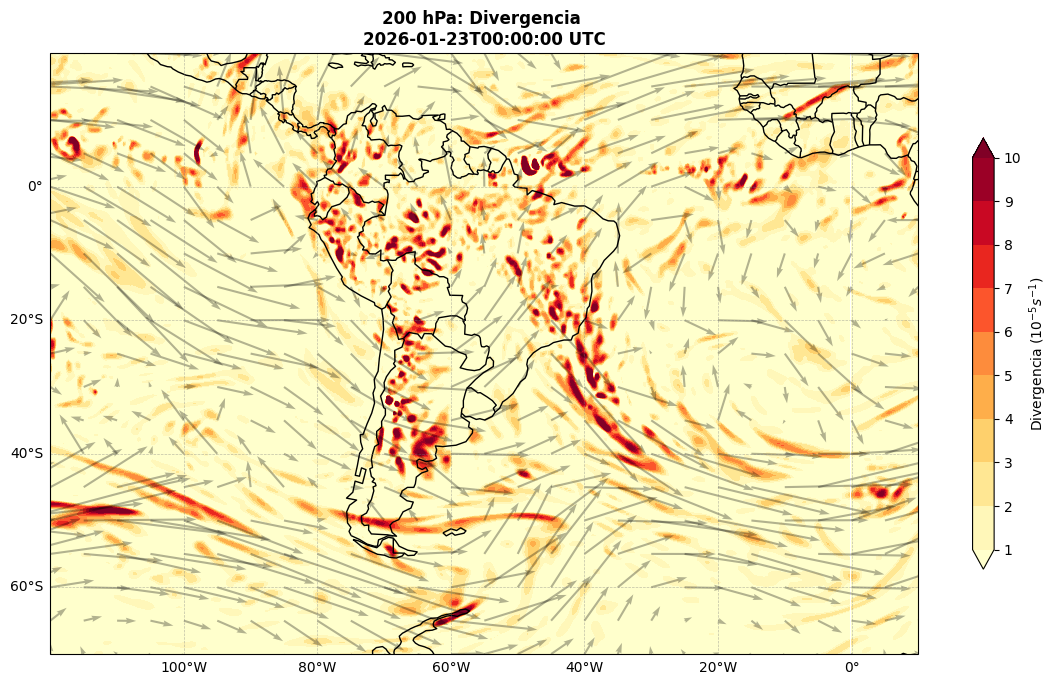

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Cargar datos
dh = xr.open_dataset(r"/content/drive/MyDrive/Colab Notebooks/humedad.nc")

# 2. Selección de nivel y fecha
fecha_query = '2026-01-23T00:00:00'
ds_200 = dh.sel(pressure_level=200, valid_time=fecha_query, method='nearest')

if 'expver' in ds_200.dims:
    ds_200 = ds_200.sel(expver=1).combine_first(ds_200.sel(expver=5))

# --- CÁLCULO DE DIVERGENCIA ---
# Multiplicamos por 1e5 para que los valores sean legibles (ej. 2, 4, 6...)
div_escala = ds_200.d * 1e5

# 3. Graficación
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-120, 10, -70, 20], crs=ccrs.PlateCarree())

# Capa 1: Divergencia (Sombreado)
# Usamos niveles positivos para resaltar el ascenso (divergencia)
niveles_div = np.linspace(1, 10, 10)
im = ax.contourf(ds_200.longitude, ds_200.latitude, div_escala,
                 levels=niveles_div, cmap="YlOrRd", extend='both')

# Capa 2: Vectores de viento (Opcional, solo para referencia de flujo)
skip = 20
ax.quiver(ds_200.longitude[::skip], ds_200.latitude[::skip],
          ds_200.u[::skip, ::skip], ds_200.v[::skip, ::skip],
          color='black', alpha=0.3, scale=400, transform=ccrs.PlateCarree())

# Detalles geográficos
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle='-')
plt.colorbar(im, label='Divergencia ($10^{-5} s^{-1}$)', shrink=0.7)
# 4. Cuadrícula y Coordenada

gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False
ax.set_title(f"200 hPa: Divergencia \n{fecha_query} UTC", fontweight='bold')
plt.show()

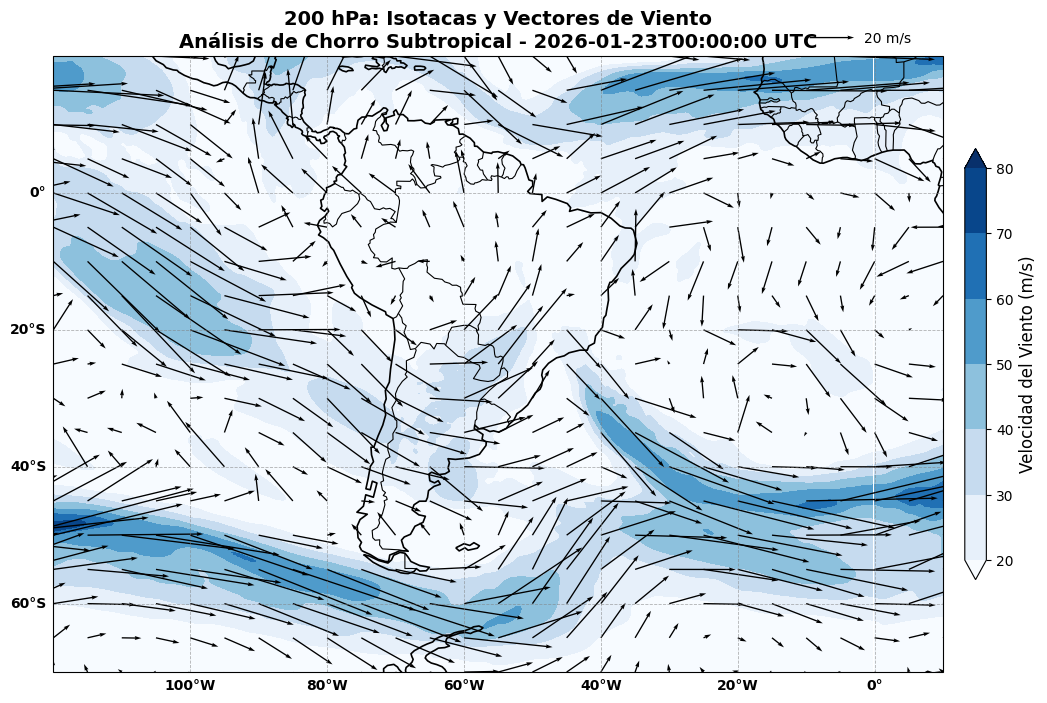

In [18]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Cargar datos
dh = xr.open_dataset(r"/content/drive/MyDrive/Colab Notebooks/humedad.nc")

# 2. Selección de nivel 200 hPa y fecha
fecha_query = '2026-01-23T00:00:00'
ds_200 = dh.sel(pressure_level=200, valid_time=fecha_query, method='nearest')

# Limpieza de dimensión expver si existe
if 'expver' in ds_200.dims:
    ds_200 = ds_200.sel(expver=1).combine_first(ds_200.sel(expver=5))

# --- CÁLCULOS ---
# Magnitud del viento (Isotacas)
velocidad = np.sqrt(ds_200.u**2 + ds_200.v**2)

# 3. Graficación
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Extensión solicitada
ax.set_extent([-120, 10, -70, 20], crs=ccrs.PlateCarree())

# Capa 1: Isotacas (Sombreado)
# Usamos una paleta 'YlOrRd' (Amarillo-Naranja-Rojo) para resaltar el Chorro
niveles_viento = np.arange(20, 81, 10)
im = ax.contourf(ds_200.longitude, ds_200.latitude, velocidad,
                 levels=niveles_viento, cmap="Blues", extend='both', transform=ccrs.PlateCarree())

# Capa 2: Vectores de Viento (Quiver)
# Ajustamos el skip para que no se amontonen las flechas
skip = 20
q = ax.quiver(ds_200.longitude[::skip], ds_200.latitude[::skip],
              ds_200.u[::skip, ::skip], ds_200.v[::skip, ::skip],
              color='black', scale=400, width=0.0015, transform=ccrs.PlateCarree())

# Leyenda de los vectores
ax.quiverkey(q, X=0.9, Y=1.03, U=20, label='20 m/s', labelpos='E')

# 4. Grillas y Coordenadas (Indispensable)
gl = ax.gridlines(draw_labels=True, linewidth=0.6, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'weight': 'bold'}
gl.ylabel_style = {'size': 10, 'weight': 'bold'}

# 5. Detalles geográficos
ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='none', edgecolor='black')

# Título y Barra de colores
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
cbar.set_label('Velocidad del Viento (m/s)', fontsize=12)

ax.set_title(f"200 hPa: Isotacas y Vectores de Viento\nAnálisis de Chorro Subtropical - {fecha_query} UTC",
             fontweight='bold', fontsize=14)

plt.show()

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from cartopy.util import add_cyclic_point

# 1. CARGAR DATOS
# Asegúrate de que la ruta al archivo sea correcta en tu PC
ds = xr.open_dataset(r"D:\sinop\lluvia.nc")

# 2. SELECCIÓN DE VARIABLE Y PERIODO
precip = ds['tp']
data_slice = precip.sel(valid_time=slice('2026-01-22T12:00', '2026-01-23T12:00'))

# 3. CONVERSIÓN Y LIMPIEZA CLAVE
# Pasamos de metros a milímetros
data_slice = data_slice * 1000.0

# ESTA LÍNEA ELIMINA EL FONDO OSCURO:
# Le dice a Python que ignore los valores menores a 0.1 mm (que sea transparente)
data_slice = data_slice.where(data_slice > 0.1)

# 4. CONFIGURACIÓN DE LA FIGURA
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Definimos niveles de lluvia y el mapa de colores (puedes usar 'turbo' o 'Blues')
levels = [0.1, 1, 2, 5, 10, 15, 20, 25, 30, 35]
cmap = plt.get_cmap("turbo") 

# Barra de colores estática (se queda a la derecha y no se mueve)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=35))
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02, aspect=25, shrink=0.7)
cbar.set_label('Precipitación Total (mm)', fontsize=10, fontweight='bold')

def actualizar(i):
    ax.clear()
    
    # Obtener el paso de tiempo actual
    step_data = data_slice.isel(valid_time=i)
    
    # 5. PUNTO CÍCLICO (Evita la línea blanca vertical en lon 0)
    data_cyc, lon_cyc = add_cyclic_point(step_data.values, coord=step_data.longitude)
    
    # 6. ESTÉTICA DEL MAPA
    ax.set_extent([-85, -30, -50, 10], crs=ccrs.PlateCarree()) 
    
    # Capas de fondo (zorder controla qué va encima de qué)
    ax.add_feature(cfeature.OCEAN, facecolor='#e0f3ff', zorder=0)  # Mar azul claro
    ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', zorder=1)   # Tierra gris claro
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black', zorder=4)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6, linestyle='-', edgecolor='#444444', zorder=4)
    
    # 7. GRAFICAR LA LLUVIA
    # Solo se graficarán los valores que no son "NaN" (gracias al .where del paso 3)
    im = ax.contourf(
        lon_cyc, step_data.latitude, data_cyc,
        levels=levels,
        cmap=cmap,
        extend="max",
        transform=ccrs.PlateCarree(),
        zorder=3
    )
    
    # 8. TÍTULOS DINÁMICOS
    fecha_dt = step_data.valid_time.values
    fecha_str = np.datetime_as_string(fecha_dt, unit='h')
    
    ax.set_title(f"Precipitación Total\nFecha: {fecha_str} UTC", 
                 fontsize=13, fontweight='bold', pad=15)
    
    # Cuadrícula de coordenadas
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

# 9. CREAR LA ANIMACIÓN
print("Procesando fotogramas...")
ani = FuncAnimation(fig, actualizar, frames=len(data_slice.valid_time), interval=300)
plt.close() # Evita que se muestre una imagen estática extra al final

# 10. MOSTRAR EN JUPYTER / COLAB
HTML(ani.to_jshtml())

Procesando fotogramas...
